# Analysis of muon simulations
In this notebook, we aim to analyse the simulations of muon passage with main focus on particles involved, the deposited energy in correlation with time and space.

In [14]:
# import libraries and load data (only meaningful fields)
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 30})

fields = ["PID", "ParentTrackID", "energydeposition", "kineticenergy", "time", "x", "y", "z", "eventnumber", "parentnucleusPID", "creatorprocess"]
file_path = os.path.join("..", "Data", "output123456789.csv")
df = pd.read_csv(file_path, index_col=False)[fields]
df.head()

,PID,ParentTrackID,energydeposition,kineticenergy,time,x,y,z,eventnumber,parentnucleusPID,creatorprocess
0,13,0,5375.22,279243000.0,53.5999,1139.06,1065.57,1950.00,0,0,None
1,13,0,4200.84,279238000.0,53.6688,1139.06,1065.58,1921.16,0,0,None
2,13,0,4811.86,279233000.0,53.7515,1139.05,1065.58,1900.49,0,0,None
3,13,0,2344.09,279227000.0,53.7971,1139.04,1065.59,1875.69,0,0,None
4,13,0,8229.72,279218000.0,53.9409,1139.04,1065.59,1862.05,0,0,None


## Muon particles: energy deposition, elapsed time and covered space
First, we extract the entries of muon particles to analyse the deposited energy, the elapsed time and the approximate covered space of the whole muon passage. To this aim, we proceed as follow:
1. consider only the entries of muon particles (PID=13) with energy deposition > 0
1. consider only the entries of muon particles, sort them on `time` and compute the elapsed time as `elapsed_time = time[-1] - time[0]`, and the covered space `distance = norm(coord_f - coord_0)`

### Energy deposition
Muons bring very high kinetic energy (*i.e. order of 280 GeV*). During the passage in the LAr volume, they release this energy by energy depositions. Here, we profile the distribution of energy depositions over the passage.

Energy deposition over each event.
count    14070.000000
mean      5204.462866
std       5186.855864
min          0.061651
25%       1467.240000
50%       3618.445000
75%       7264.485000
max      44631.800000
Name: energydeposition, dtype: float64


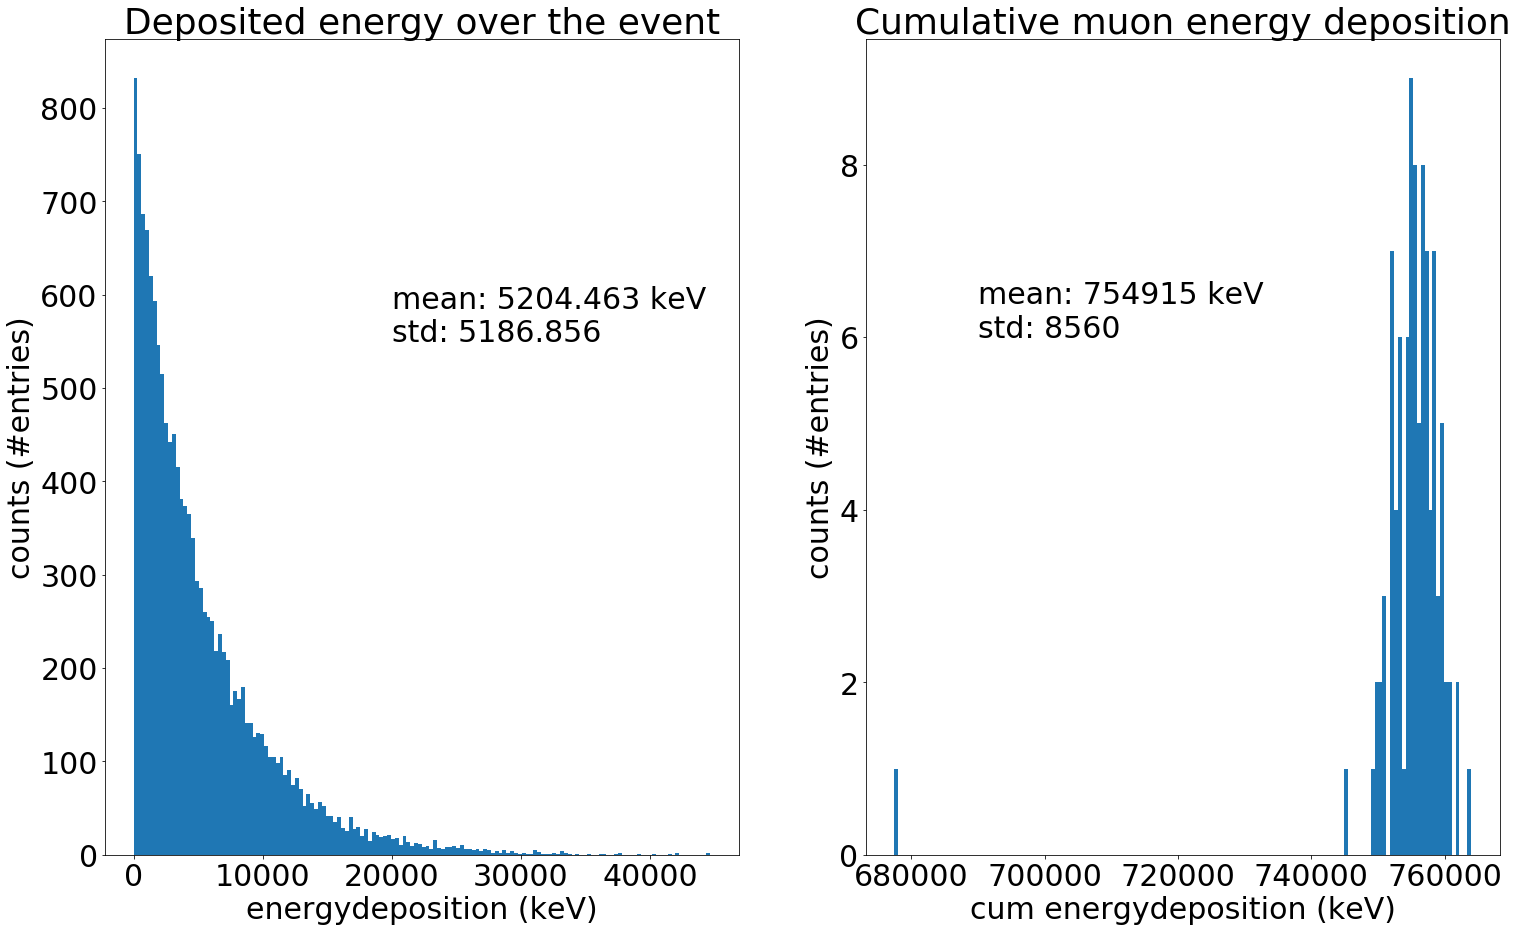

In [53]:
# analyse energy deposition
muons = df[df.PID==13]
muon_energies = muons[muons.energydeposition>0].energydeposition
cum_energy = muons.groupby("eventnumber").energydeposition.sum()
stat = muon_energies.describe()                 # collect statistics
cum_stat = cum_energy.describe()                 # collect statistics
print("Energy deposition over each event.\n{}".format(stat))
mean_e, std_e = stat["mean"], stat["std"]       # mean, std dev

plt.subplot(1, 2, 1)
plt.hist(muon_energies, 150)                    # plot energy distribution wt 500 bins
plt.title("Deposited energy over the event")
plt.xlabel("energydeposition (keV)")
plt.ylabel("counts (#entries)")
plt.text(20000, 550, "mean: %.3f keV\nstd: %.3f" % (mean_e, std_e))
plt.subplot(1, 2, 2)
plt.hist(cum_energy.values, 150)
plt.title("Cumulative muon energy deposition")
plt.xlabel("cum energydeposition (keV)")
plt.ylabel("counts (#entries)")
plt.text(690000, 6, "mean: %d keV\nstd: %d" % (cum_stat["mean"], cum_stat["std"]))
plt.show()

### Time and space

In [16]:
# analyse elapsed time and space covered (approx distance between final and initial coordinate)
gb_event = muons.sort_values("time").groupby("eventnumber")
time_space = pd.DataFrame()
time_space["time_0"] = gb_event.time.first()
time_space["time_f"] = gb_event.time.last()
time_space["elapsed_time"] = time_space["time_f"] - time_space["time_0"]
time_space["x_0"], time_space["y_0"], time_space["z_0"] = gb_event.x.first(), gb_event.y.first(), gb_event.z.first()
time_space["x_f"], time_space["y_f"], time_space["z_f"] = gb_event.x.last(), gb_event.y.last(), gb_event.z.last()
coord0 = time_space[["x_0", "y_0", "z_0"]].values
coordf = time_space[["x_f", "y_f", "z_f"]].values
time_space["distance"] = (((coord0-coordf)**2).sum(axis=1))**0.5
time_space.head()

,time_0,time_f,elapsed_time,x_0,y_0,z_0,x_f,y_f,z_f,distance
eventnumber,,,,,,,,,,
0,53.5999,66.5127,12.9128,1139.060,1065.570,1950.0,1137.850,1066.740,-1919.23,3869.230366
1,53.5733,66.5127,12.9394,1859.860,467.313,1950.0,1857.440,468.168,-1906.62,3856.620854
2,53.6941,66.5127,12.8186,-439.537,-1344.410,1950.0,-440.326,-1346.550,-1948.98,3898.980667
3,53.6037,66.5127,12.9090,1561.810,303.209,1950.0,1561.200,302.711,-1921.35,3871.350080
4,53.6852,66.5127,12.8275,809.192,-1597.620,1950.0,809.883,-1597.450,-1905.31,3855.310066


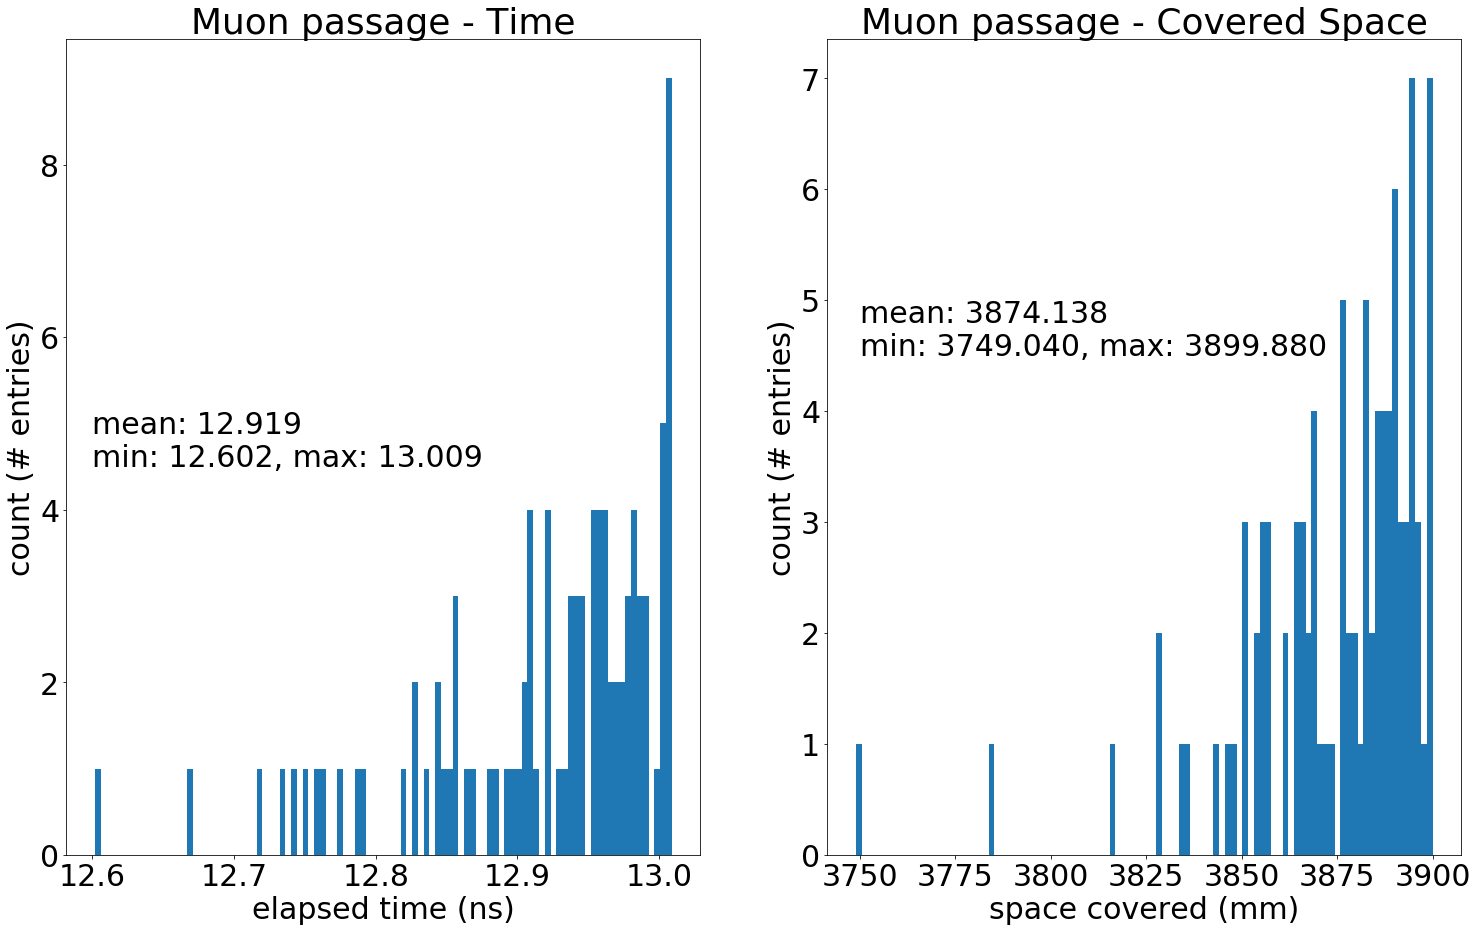

In [55]:
times = time_space.elapsed_time
stat = times.describe()
min_t, max_t, mean_t = stat["min"], stat["max"], stat["mean"]
distances = time_space.distance
stat = distances.describe()
min_d, max_d, mean_d = stat["min"], stat["max"], stat["mean"]
plt.subplot(1, 2, 1)
plt.hist(times, 100)
plt.text(12.6, 4.5, "mean: %.3f\nmin: %.3f, max: %.3f" % (mean_t, min_t, max_t))
plt.title("Muon passage - Time")
plt.xlabel("elapsed time (ns)")
plt.ylabel("count (# entries)")
plt.subplot(1, 2, 2)
plt.hist(distances, 100)
plt.text(3750, 4.5, "mean: %.3f\nmin: %.3f, max: %.3f" % (mean_d, min_d, max_d))
plt.title("Muon passage - Covered Space")
plt.xlabel("space covered (mm)")
plt.ylabel("count (# entries)")
plt.show()


### Observations:
- muons deposit a lot of **energy** ~750MeV (*cumulative energy deposited in LAr*)
- the energy is deposited over the passage in LAr. Each **deposition** is in order of ~5MeV, with a lot of small depositions (*75% is below 7.5MeV*) and few high depositions (*25% in 10-40MeV*)
- considering the **space** and **time** between the first and the last deposition: each muon covers ~3.8 meters and spends ~13 ns to cross the LAr volume